**Face Mask Detection**

Program Machine Learning untuk mendeteksi penggunaan masker. Program dibuat menggunakan metode CNN dengan arsitektur VGG16Net dan MTCNN untuk face detection.


## Mengimpor Libraries yang dibutuhkan


In [1]:
!git clone https://github.com/georgejusen/Skripsi

fatal: destination path 'Skripsi' already exists and is not an empty directory.


In [2]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools
import sys
from PIL import Image

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

!nvidia-smi


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  2
Sun Nov 26 15:26:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |    308MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |         

## Preprocessing Datasets


In [4]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size

INIT_LR = 1e-4
EPOCHS = 100
BS = 32
lipatan = 7

# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")

# imagePaths = list(paths.list_images('dataset'))
imagePaths = list(paths.list_images("/kaggle/working/Skripsi/dataset"))
data = []
labels = []

# Melakukan perulangan pada image paths
for imagePath in imagePaths:

    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)

# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

Menginput gambar...


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Input gambar berhasil


### Membuat objek ImageDataGenerator dan Data Augmentation


In [5]:
# Mempartisi data ke dalam pelatihan dan pengujian ( 75% : 25% )
'''
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.25, stratify=labels, random_state=42)
 '''


# Membentuk training image generator untuk data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (pre-trained convnets)


In [6]:
# Arsitektur jaringan VGG16Net
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

### Feature Extraction


In [7]:
baseModel.trainable = False
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Tahap Pembuatan Model


In [8]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Mengkompilasi model...
fold 1
Training head model...
Epoch 1/100
102/102 [==============================] - 54s 456ms/step - loss: 0.6857 - accuracy: 0.6019 - val_loss: 0.6075 - val_accuracy: 0.9015
Epoch 2/100
102/102 [==============================] - 36s 348ms/step - loss: 0.5810 - accuracy: 0.8119 - val_loss: 0.5080 - val_accuracy: 0.9343
Epoch 3/100
102/102 [==============================] - 36s 347ms/step - loss: 0.4996 - accuracy: 0.8718 - val_loss: 0.4224 - val_accuracy: 0.9398
Epoch 4/100
102/102 [==============================] - 36s 353ms/step - loss: 0.4340 - accuracy: 0.9010 - val_loss: 0.3539 - val_accuracy: 0.9471
Epoch 5/100
102/102 [==============================] - 35s 346ms/step - loss: 0.3718 - accuracy: 0.9185 - val_loss: 0.3032 - val_accuracy: 0.9416
Epoch 6/100
102/102 [==============================] - 36s 357ms/step - loss: 0.3270 - accuracy: 0.9238 - val_loss: 0.2537 - val_accuracy: 0.9507
Epoch 7/100
102/102 [==============================] - 36s 350ms/step -

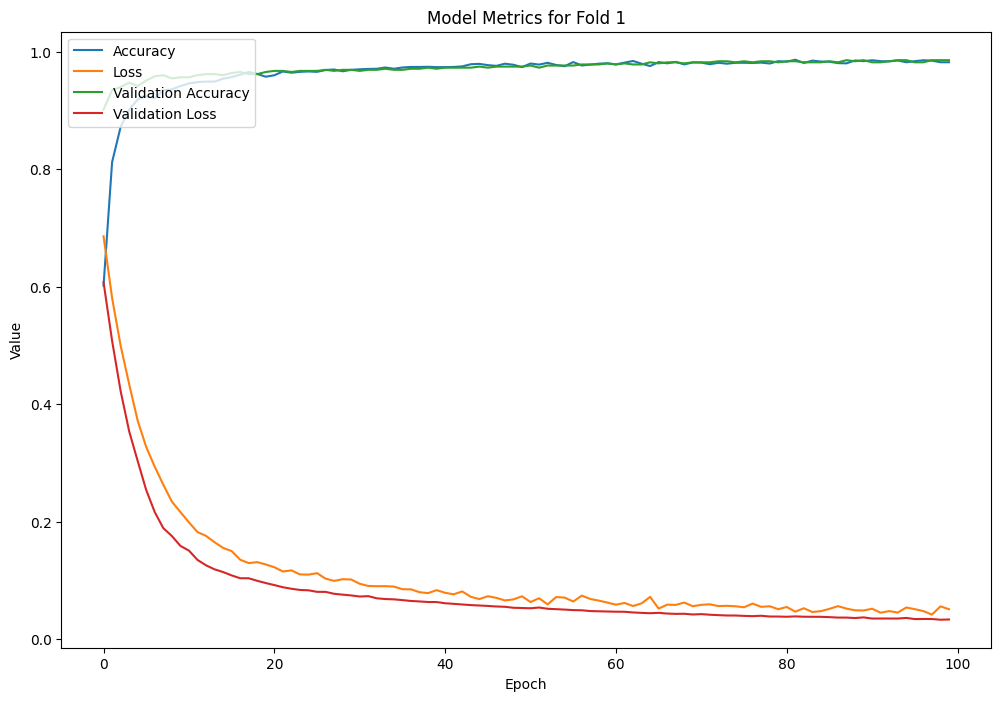

Mengkompilasi model...
fold 2
Training head model...
Epoch 1/100
102/102 [==============================] - 37s 356ms/step - loss: 0.0523 - accuracy: 0.9806 - val_loss: 0.0278 - val_accuracy: 0.9909
Epoch 2/100
102/102 [==============================] - 36s 350ms/step - loss: 0.0470 - accuracy: 0.9828 - val_loss: 0.0280 - val_accuracy: 0.9909
Epoch 3/100
102/102 [==============================] - 37s 364ms/step - loss: 0.0446 - accuracy: 0.9849 - val_loss: 0.0296 - val_accuracy: 0.9927
Epoch 4/100
102/102 [==============================] - 37s 357ms/step - loss: 0.0533 - accuracy: 0.9812 - val_loss: 0.0291 - val_accuracy: 0.9927
Epoch 5/100
102/102 [==============================] - 37s 357ms/step - loss: 0.0481 - accuracy: 0.9834 - val_loss: 0.0285 - val_accuracy: 0.9927
Epoch 6/100
102/102 [==============================] - 36s 347ms/step - loss: 0.0445 - accuracy: 0.9825 - val_loss: 0.0283 - val_accuracy: 0.9909
Epoch 7/100
102/102 [==============================] - 36s 347ms/step -

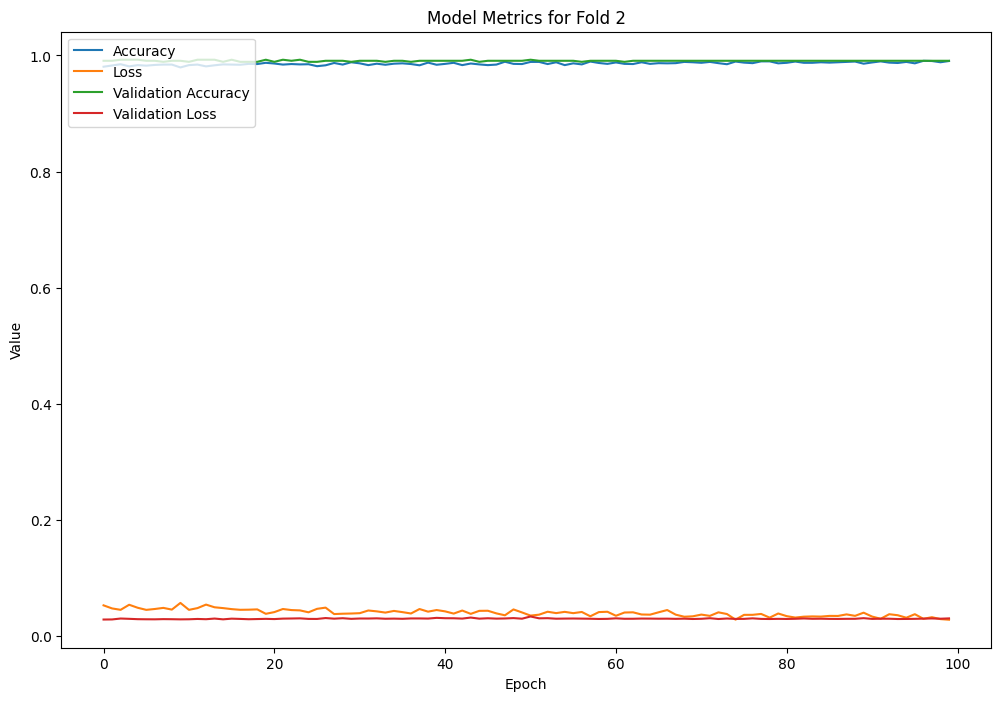

Mengkompilasi model...
fold 3
Training head model...
Epoch 1/100
102/102 [==============================] - 38s 363ms/step - loss: 0.0345 - accuracy: 0.9895 - val_loss: 0.0107 - val_accuracy: 0.9945
Epoch 2/100
102/102 [==============================] - 35s 345ms/step - loss: 0.0308 - accuracy: 0.9902 - val_loss: 0.0111 - val_accuracy: 0.9964
Epoch 3/100
102/102 [==============================] - 36s 350ms/step - loss: 0.0377 - accuracy: 0.9871 - val_loss: 0.0118 - val_accuracy: 0.9964
Epoch 4/100
102/102 [==============================] - 35s 343ms/step - loss: 0.0358 - accuracy: 0.9892 - val_loss: 0.0114 - val_accuracy: 0.9945
Epoch 5/100
102/102 [==============================] - 35s 346ms/step - loss: 0.0350 - accuracy: 0.9892 - val_loss: 0.0117 - val_accuracy: 0.9964
Epoch 6/100
102/102 [==============================] - 36s 348ms/step - loss: 0.0392 - accuracy: 0.9868 - val_loss: 0.0117 - val_accuracy: 0.9964
Epoch 7/100
102/102 [==============================] - 35s 346ms/step -

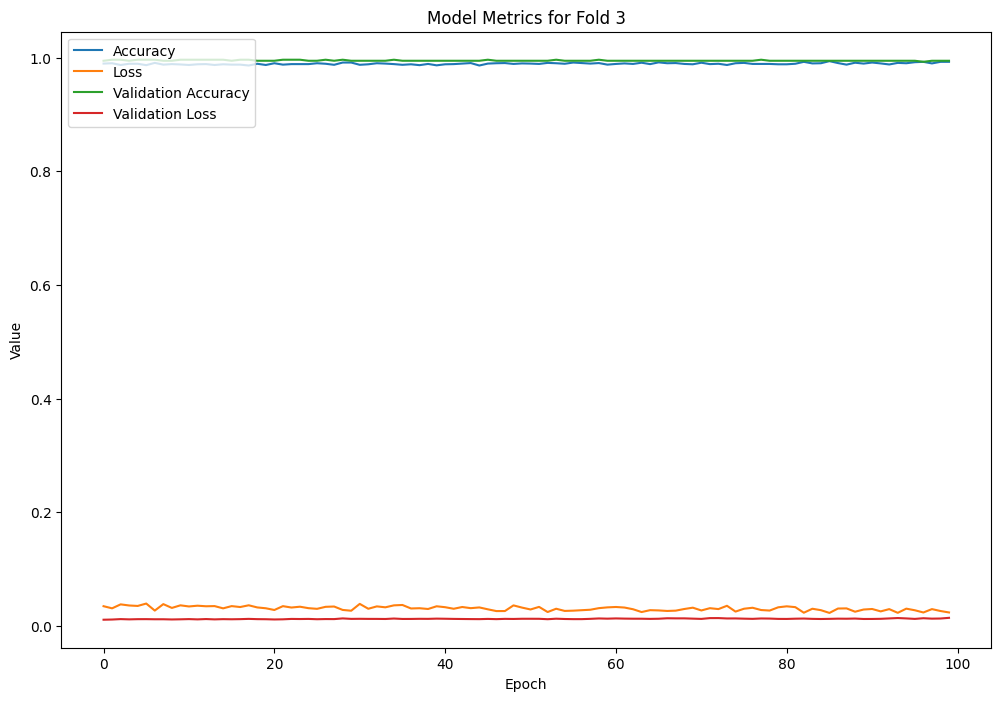

Mengkompilasi model...
fold 4
Training head model...
Epoch 1/100
102/102 [==============================] - 38s 360ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.0205 - val_accuracy: 0.9945
Epoch 2/100
102/102 [==============================] - 36s 351ms/step - loss: 0.0266 - accuracy: 0.9883 - val_loss: 0.0210 - val_accuracy: 0.9945
Epoch 3/100
102/102 [==============================] - 36s 348ms/step - loss: 0.0272 - accuracy: 0.9911 - val_loss: 0.0207 - val_accuracy: 0.9945
Epoch 4/100
102/102 [==============================] - 36s 351ms/step - loss: 0.0287 - accuracy: 0.9902 - val_loss: 0.0203 - val_accuracy: 0.9945
Epoch 5/100
102/102 [==============================] - 35s 345ms/step - loss: 0.0257 - accuracy: 0.9902 - val_loss: 0.0202 - val_accuracy: 0.9945
Epoch 6/100
102/102 [==============================] - 35s 347ms/step - loss: 0.0292 - accuracy: 0.9905 - val_loss: 0.0200 - val_accuracy: 0.9945
Epoch 7/100
102/102 [==============================] - 37s 359ms/step -

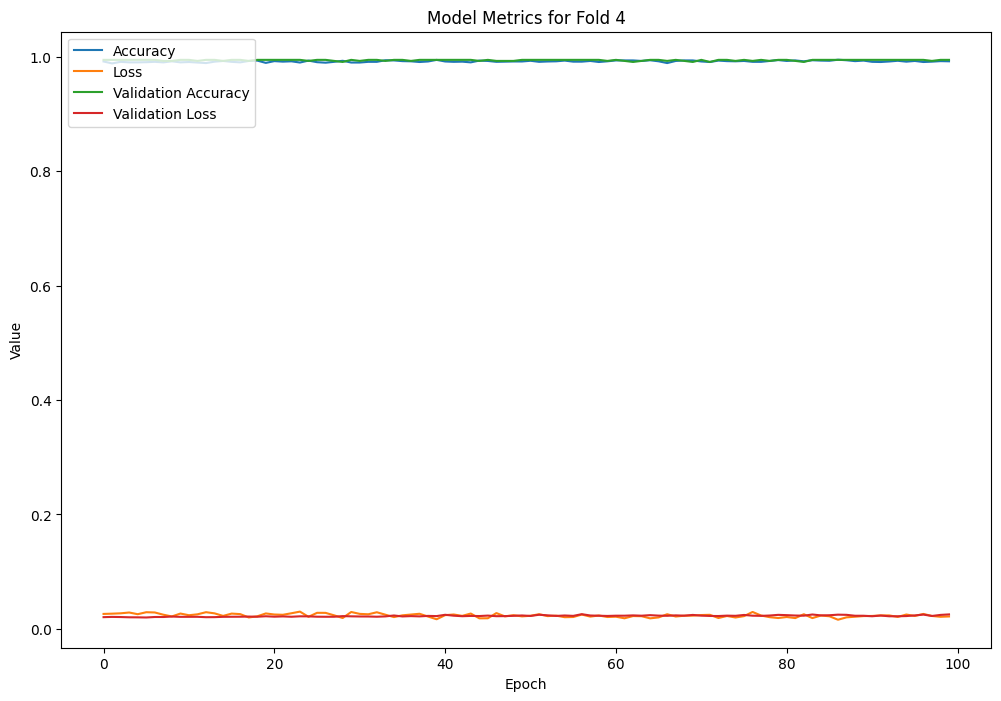

Mengkompilasi model...
fold 5
Training head model...
Epoch 1/100
102/102 [==============================] - 43s 409ms/step - loss: 0.0271 - accuracy: 0.9923 - val_loss: 0.0043 - val_accuracy: 0.9982
Epoch 2/100
102/102 [==============================] - 36s 353ms/step - loss: 0.0205 - accuracy: 0.9926 - val_loss: 0.0044 - val_accuracy: 0.9982
Epoch 3/100
102/102 [==============================] - 36s 353ms/step - loss: 0.0271 - accuracy: 0.9914 - val_loss: 0.0039 - val_accuracy: 0.9982
Epoch 4/100
102/102 [==============================] - 37s 361ms/step - loss: 0.0239 - accuracy: 0.9902 - val_loss: 0.0037 - val_accuracy: 0.9982
Epoch 5/100
102/102 [==============================] - 36s 356ms/step - loss: 0.0200 - accuracy: 0.9932 - val_loss: 0.0049 - val_accuracy: 0.9982
Epoch 6/100
102/102 [==============================] - 36s 353ms/step - loss: 0.0254 - accuracy: 0.9914 - val_loss: 0.0047 - val_accuracy: 0.9982
Epoch 7/100
102/102 [==============================] - 36s 354ms/step -

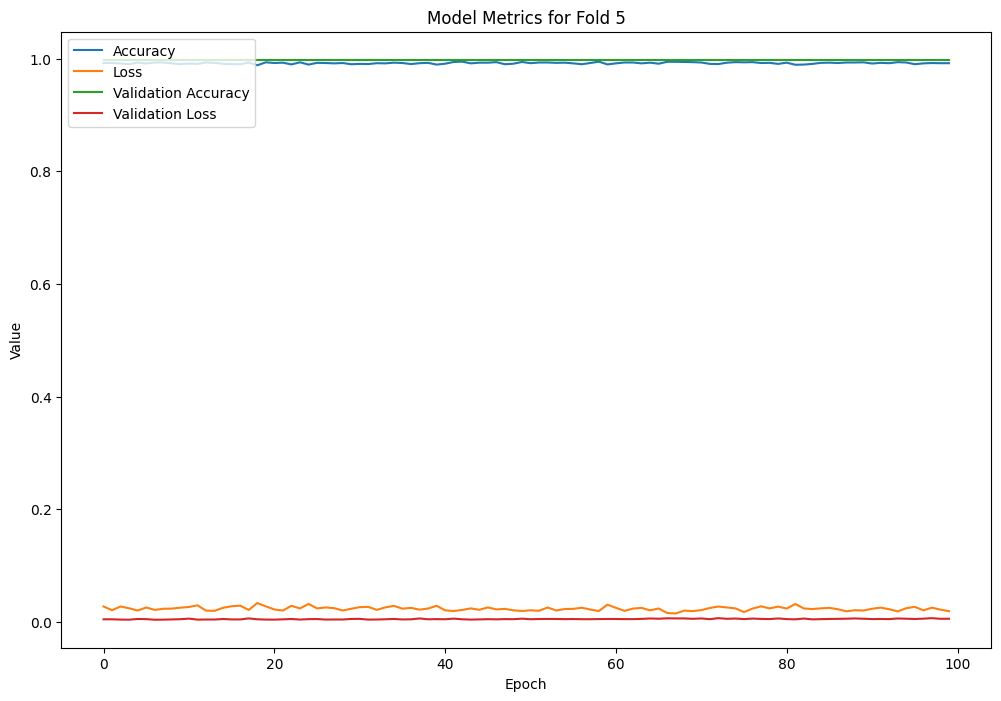

Mengkompilasi model...
fold 6
Training head model...
Epoch 1/100
102/102 [==============================] - 38s 361ms/step - loss: 0.0186 - accuracy: 0.9923 - val_loss: 0.0040 - val_accuracy: 0.9982
Epoch 2/100
102/102 [==============================] - 36s 355ms/step - loss: 0.0220 - accuracy: 0.9917 - val_loss: 0.0040 - val_accuracy: 0.9982
Epoch 3/100
102/102 [==============================] - 36s 351ms/step - loss: 0.0200 - accuracy: 0.9932 - val_loss: 0.0041 - val_accuracy: 0.9982
Epoch 4/100
102/102 [==============================] - 36s 352ms/step - loss: 0.0206 - accuracy: 0.9942 - val_loss: 0.0030 - val_accuracy: 0.9982
Epoch 5/100
102/102 [==============================] - 36s 351ms/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.0041 - val_accuracy: 0.9982
Epoch 6/100
102/102 [==============================] - 37s 359ms/step - loss: 0.0174 - accuracy: 0.9935 - val_loss: 0.0039 - val_accuracy: 0.9982
Epoch 7/100
102/102 [==============================] - 36s 349ms/step -

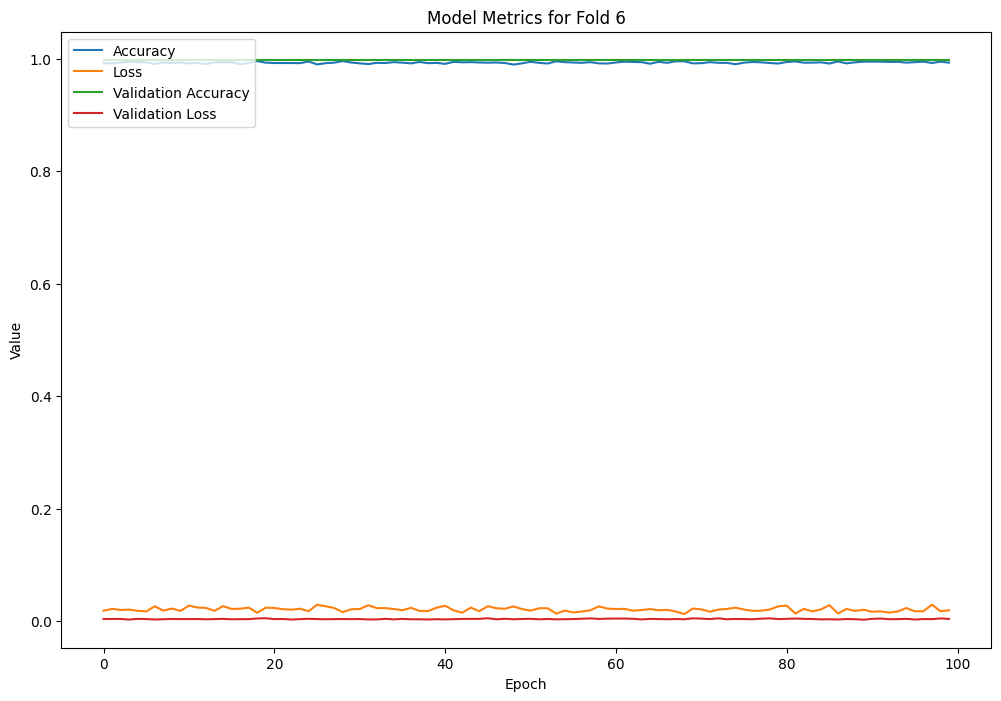

Mengkompilasi model...
fold 7
Training head model...
Epoch 1/100
102/102 [==============================] - 38s 366ms/step - loss: 0.0225 - accuracy: 0.9939 - val_loss: 0.0043 - val_accuracy: 0.9982
Epoch 2/100
102/102 [==============================] - 36s 352ms/step - loss: 0.0171 - accuracy: 0.9926 - val_loss: 0.0042 - val_accuracy: 0.9982
Epoch 3/100
102/102 [==============================] - 36s 356ms/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0044 - val_accuracy: 0.9982
Epoch 4/100
102/102 [==============================] - 36s 351ms/step - loss: 0.0155 - accuracy: 0.9951 - val_loss: 0.0058 - val_accuracy: 0.9982
Epoch 5/100
102/102 [==============================] - 36s 354ms/step - loss: 0.0252 - accuracy: 0.9914 - val_loss: 0.0044 - val_accuracy: 0.9982
Epoch 6/100
102/102 [==============================] - 36s 355ms/step - loss: 0.0171 - accuracy: 0.9939 - val_loss: 0.0045 - val_accuracy: 0.9982
Epoch 7/100
102/102 [==============================] - 37s 359ms/step -

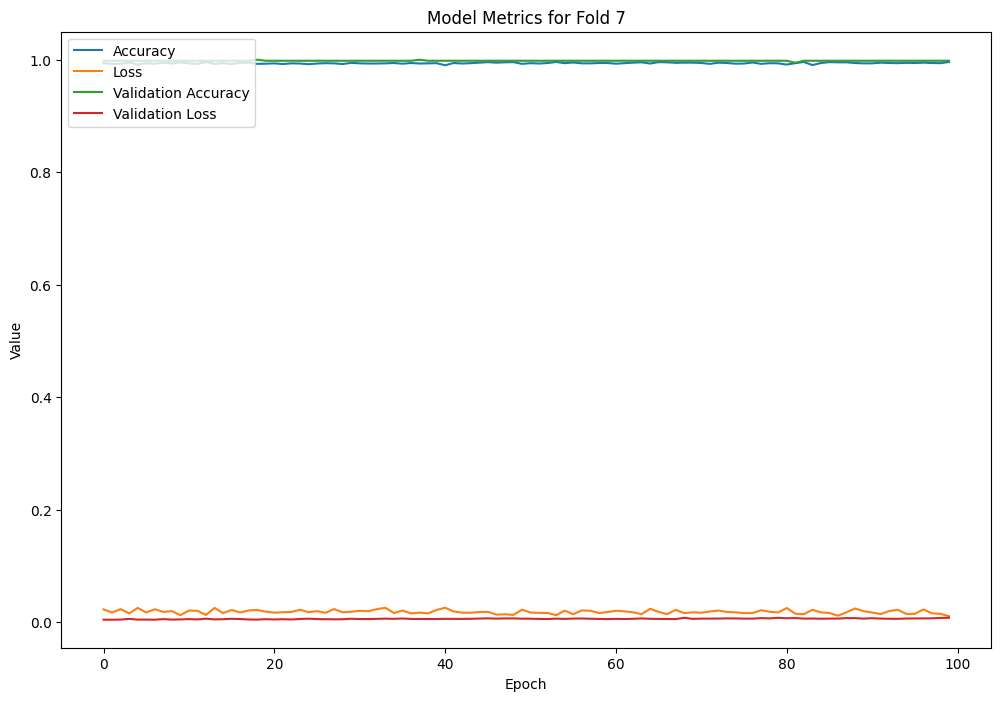

Fold 1 - Accuracy: 0.9854, F1 Score: 0.9853, Precision: 0.9856, Recall: 0.9851
Fold 2 - Accuracy: 0.9909, F1 Score: 0.9909, Precision: 0.9909, Recall: 0.9909
Fold 3 - Accuracy: 0.9945, F1 Score: 0.9945, Precision: 0.9946, Recall: 0.9944
Fold 4 - Accuracy: 0.9945, F1 Score: 0.9945, Precision: 0.9945, Recall: 0.9946
Fold 5 - Accuracy: 0.9982, F1 Score: 0.9982, Precision: 0.9982, Recall: 0.9981
Fold 6 - Accuracy: 0.9982, F1 Score: 0.9982, Precision: 0.9982, Recall: 0.9981
Fold 7 - Accuracy: 0.9982, F1 Score: 0.9982, Precision: 0.9982, Recall: 0.9982


In [9]:

kf = KFold(n_splits=lipatan, shuffle=True)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
history = []

fold = 1
for train_index, test_index in kf.split(data):
    print("Mengkompilasi model...")
    print("fold", fold)

    train_data, train_labels = data[train_index], labels[train_index]
    test_data, test_labels = data[test_index], labels[test_index]

    opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    print("Training head model...")

    H = model.fit(
        aug.flow(train_data, train_labels, batch_size=BS),
        steps_per_epoch=len(train_data) // BS,
        validation_data=(test_data, test_labels),
        validation_steps=len(test_data) // BS,
        epochs=EPOCHS)

    history.append(H)

    loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
    fold_accuracies.append(accuracy)

    predictions = model.predict(test_data)
    predictions = np.round(predictions)
    f1 = f1_score(test_labels, predictions, average='macro')
    precision = precision_score(test_labels, predictions, average='macro')
    recall = recall_score(test_labels, predictions, average='macro')
    fold_f1_scores.append(f1)
    fold_precisions.append(precision)
    fold_recalls.append(recall)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(H.history['accuracy'])
    plt.plot(H.history['loss'])
    plt.plot(H.history['val_accuracy'])
    plt.plot(H.history['val_loss'])
    plt.title('Model Metrics for Fold {}'.format(fold))
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Loss', 'Validation Accuracy', 'Validation Loss'], loc='upper left')
    plt.show()

    fold += 1

for fold, accuracy, f1, precision, recall in zip(range(1, fold+1), fold_accuracies, fold_f1_scores, fold_precisions, fold_recalls):
    print(f"Fold {fold} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


## Evaluasi Jaringan


Average Accuracy: 0.9943
Standard Deviation of Accuracy: 0.0044
Best Fold: 5 with Accuracy = 0.9982
Worst Fold: 1 with Accuracy = 0.9854


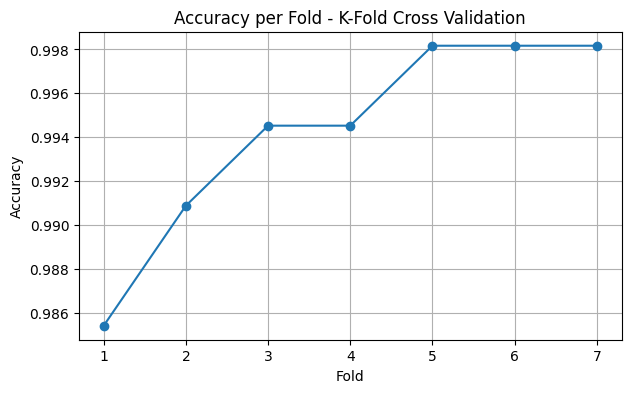

In [10]:
average_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy: {average_accuracy:.4f}")

# Standard deviation of accuracy across all folds
std_accuracy = np.std(fold_accuracies)
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

# Find the best and worst fold
best_fold = np.argmax(fold_accuracies)
worst_fold = np.argmin(fold_accuracies)

print(f"Best Fold: {best_fold + 1} with Accuracy = {fold_accuracies[best_fold]:.4f}")
print(f"Worst Fold: {worst_fold + 1} with Accuracy = {fold_accuracies[worst_fold]:.4f}")

# Plot the accuracy per fold
plt.figure(figsize=(7, 4))
plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy per Fold - K-Fold Cross Validation')
plt.xticks(range(1, len(fold_accuracies) + 1))
plt.grid(True)
plt.show()